In [69]:
# 📘 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib  # For saving model


In [70]:
# 📂 2. Load Dataset
df = pd.read_csv("/kaggle/input/phishing-site-urls/phishing_site_urls.csv")  # Replace with your actual file
df.head()


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [71]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

In [72]:
df.duplicated().sum()


42150

In [73]:
df.drop_duplicates(inplace=True)


In [74]:
df.duplicated().sum()


0

Dataset shape: (507196, 2)
Null values:
 URL      0
Label    0
dtype: int64
Label distribution:
 Label
good    392897
bad     114299
Name: count, dtype: int64


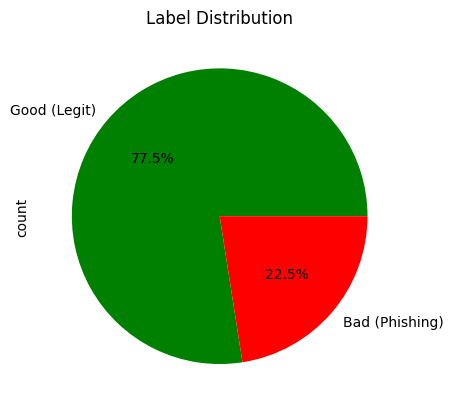

In [75]:
# 🔍 3. Explore the Dataset
print("Dataset shape:", df.shape)
print("Null values:\n", df.isnull().sum())
print("Label distribution:\n", df['Label'].value_counts())

# Pie chart
df['Label'].value_counts().plot.pie(autopct="%1.1f%%", labels=["Good (Legit)", "Bad (Phishing)"], colors=["green", "red"])
plt.title("Label Distribution")
plt.show()


In [76]:
# 🧹 4. Preprocessing
# Encode labels: Good → 1 (Legit), Bad → 0 (Phishing)
df['Label'] = df['Label'].map({'good': 1, 'bad': 0})
print("\nEncoded Labels:\n", df['Label'].value_counts())



Encoded Labels:
 Label
1    392897
0    114299
Name: count, dtype: int64


In [77]:
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0
...,...,...
516466,23.227.196.215/,0
516467,apple-checker.org/,0
516468,apple-iclods.org/,0
516469,apple-uptoday.org/,0


In [78]:
import re

def clean_url(url):
    url = url.lower()  # Convert to lowercase
    url = re.sub(r'https?:\/\/', '', url)  # Remove http or https
    url = re.sub(r'www\d*\.', '', url)     # Remove www or www2
    url = re.sub(r'[^a-z0-9\-\.\/]', ' ', url)  # Keep only allowed characters
    url = re.sub(r'\s+', ' ', url)         # Normalize spaces
    return url.strip()

df['clean_url'] = df['URL'].apply(clean_url)


In [79]:
# ✨ 5. Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(
    token_pattern=r"(?u)\b\w+\b", 
    ngram_range=(1, 3), 
    max_features=5000
)

X = vectorizer.fit_transform(df['clean_url'])
y = df['Label']



In [80]:
# 🔀 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=25),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Multinomial NB": MultinomialNB(),
}


In [86]:
results = []
for name, model in models.items():
    print(f"🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Phishing", "Legit"]))
    print("-" * 60)


🔍 Training: Logistic Regression
✅ Accuracy: 0.9420
              precision    recall  f1-score   support

    Phishing       0.94      0.80      0.86     22860
       Legit       0.94      0.98      0.96     78580

    accuracy                           0.94    101440
   macro avg       0.94      0.89      0.91    101440
weighted avg       0.94      0.94      0.94    101440

------------------------------------------------------------
🔍 Training: Random Forest
✅ Accuracy: 0.8605
              precision    recall  f1-score   support

    Phishing       1.00      0.38      0.55     22860
       Legit       0.85      1.00      0.92     78580

    accuracy                           0.86    101440
   macro avg       0.92      0.69      0.74    101440
weighted avg       0.88      0.86      0.84    101440

------------------------------------------------------------
🔍 Training: XGBoost
✅ Accuracy: 0.9261
              precision    recall  f1-score   support

    Phishing       0.96      0.71 

In [87]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
results_df


                 Model  Accuracy
0  Logistic Regression  0.942015
3       Multinomial NB  0.932492
2              XGBoost  0.926134
1        Random Forest  0.858507


In [88]:
# 🧠 7. Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

✅ Accuracy: 0.9420149842271294

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86     22860
           1       0.94      0.98      0.96     78580

    accuracy                           0.94    101440
   macro avg       0.94      0.89      0.91    101440
weighted avg       0.94      0.94      0.94    101440



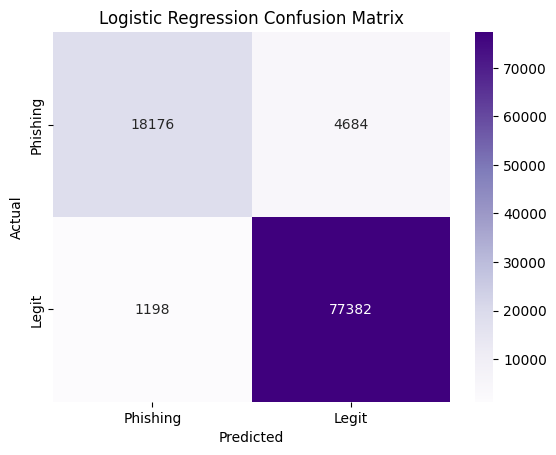

In [89]:
# 📊 8. Evaluate Model
y_pred = lr_model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Phishing', 'Legit'], yticklabels=['Phishing', 'Legit'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [102]:
sample_urls = [
    "http://login-verification-update.com",
    "https://www.paypal.com",
    "http://free-prize.ru",
    "https://www.apple.com",
    "http://password-reset-verify.org",
    "https://google.com",
    "http://bank-security-alert.co",
    "https://netflix-login-verification.com",
    "http://update-account-info.ru",
    "https://github.com"
]

# 🧹 Clean URLs
cleaned_urls = [clean_url(url) for url in sample_urls]

# 🔡 TF-IDF Vectorize
sample_features = vectorizer.transform(cleaned_urls)


In [104]:
# Predict classes (0 = phishing, 1 = legit)
predictions = lr_model.predict(sample_features)

# Predict probabilities (optional)
probabilities = lr_model.predict_proba(sample_features)[:, 1]  # Confidence for class 1 (Legit)


In [105]:
for url, pred, prob in zip(sample_urls, predictions, probabilities):
    label = "✅ Legit" if pred == 1 else "⚠️ Phishing"
    print(f"{url} => {label} ({prob * 100:.2f}%)")


http://login-verification-update.com => ⚠️ Phishing (0.00%)
https://www.paypal.com => ⚠️ Phishing (0.03%)
http://free-prize.ru => ⚠️ Phishing (12.76%)
https://www.apple.com => ✅ Legit (89.72%)
http://password-reset-verify.org => ⚠️ Phishing (3.47%)
https://google.com => ✅ Legit (83.86%)
http://bank-security-alert.co => ⚠️ Phishing (12.10%)
https://netflix-login-verification.com => ⚠️ Phishing (0.66%)
http://update-account-info.ru => ⚠️ Phishing (0.30%)
https://github.com => ✅ Legit (77.84%)


In [98]:
# 💾 10. Save Model & Vectorizer
joblib.dump(lr_model, "logistic_regression_phishing_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_lr.pkl")
print("Model and vectorizer saved.")


Model and vectorizer saved.
